# ***Random Forests***

İkinci proje olan regresyon projesinde ve üçüncü proje olan sınıflandırma projesinde kullandığınız veri kümelerini tekrar kullanarak, Rastgele Orman ile regresyon ve sınıflandırma modelleri oluşturun ve bu modeller için en uygun parametre değerlerini belirleyin. En ideal parametreyi bulmak için daha önceki bölümde öğrendiğiniz çapraz doğrulama metodlarını kullanabilirsiniz.

---

## ***Classification - Titanic***

- Siniflandirma projesinde Titanic verileriyle calismistik, burada da ayni veri setiyle calisacagiz.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
# metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# cross validation
from sklearn.model_selection import cross_validate
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# hiperparametre tuning icin
from sklearn.model_selection import GridSearchCV

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}

# veri setini dataframe icerisine yukle
titanic = pd.read_csv('data/titanic_train.csv')

### ***Veri Kesfi***
- Veri setini inceleme.

In [18]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Cabin, Ticket degiskenleri numerik olmadigindan ve burada ihtiyacimiz olmadigindan cikarabiliriz.

In [19]:
titanic = titanic.drop(['Cabin','Ticket'], axis=1)
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked'],
      dtype='object')

In [20]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

- Embarked 3 farkli deger almis, eksik veriler en sik karsilasilan degerle doldurulabilir.

In [21]:
titanic['Embarked'].fillna('S', inplace=True)

- Son olarak yas degeri de ortalama deger ile dolduruldu.

In [22]:
titanic['Age'].fillna(np.floor(titanic['Age'].mean()), inplace=True)

In [23]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


***Cinsiyet ve Liman bilgisi encode edilerek dahil edildi***

In [24]:
# get_dummies metodu ile encode edilir
titanic = pd.concat([titanic, pd.get_dummies(titanic.Sex, 
                                             drop_first=True)], axis=1)
titanic = pd.concat([titanic, pd.get_dummies(titanic.Embarked, 
                                             drop_first=True, prefix='Embarked')], axis=1)
# encode edilen sutunlar drop edilir
titanic.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [25]:
def add_title(col):
    if 'Mrs' in col:
        return 'mrs'
    elif 'Master' in col:
        return 'master'
    elif 'Mr' in col:
        return 'mr'
    elif 'Miss' in col:
        return 'miss'
    else:
        return 'no_title'

In [26]:
titanic['title'] = titanic['Name'].apply(add_title)

In [27]:
titanic['title'].unique()

array(['mr', 'mrs', 'miss', 'master', 'no_title'], dtype=object)

In [28]:
titanic = pd.concat([titanic,pd.get_dummies(titanic['title'])], axis=1)

In [29]:
titanic

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S,title,master,miss,mr,mrs,no_title
0,1,0,3,"Braund, Mr. Owen Harris",22.000,1,0,7.250,1,0,1,mr,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.000,1,0,71.283,0,0,0,mrs,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.000,0,0,7.925,0,0,1,miss,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000,1,0,53.100,0,0,1,mrs,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",35.000,0,0,8.050,1,0,1,mr,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.000,0,0,13.000,1,0,1,no_title,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.000,0,0,30.000,0,0,1,miss,0,1,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",29.000,1,2,23.450,0,0,1,miss,0,1,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",26.000,0,0,30.000,1,0,0,mr,0,0,1,0,0


In [30]:
titanic.drop(['Name', 'title', 'no_title'], axis=1, inplace=True)

In [31]:
titanic

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Embarked_Q,Embarked_S,master,miss,mr,mrs
0,1,0,3,22.000,1,0,7.250,1,0,1,0,0,1,0
1,2,1,1,38.000,1,0,71.283,0,0,0,0,0,0,1
2,3,1,3,26.000,0,0,7.925,0,0,1,0,1,0,0
3,4,1,1,35.000,1,0,53.100,0,0,1,0,0,0,1
4,5,0,3,35.000,0,0,8.050,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000,0,0,13.000,1,0,1,0,0,0,0
887,888,1,1,19.000,0,0,30.000,0,0,1,0,1,0,0
888,889,0,3,29.000,1,2,23.450,0,0,1,0,1,0,0
889,890,1,1,26.000,0,0,30.000,1,0,0,0,0,1,0


### ***Random Forest modeli***

In [32]:
X = titanic.drop(['Survived', 'PassengerId'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)

rand_forest_cl = RandomForestClassifier(n_estimators=25, random_state=2)

rand_forest_cl.fit(X_train, y_train)

rand_forest_cl.score(X_test, y_test)

0.8212290502793296

In [33]:
y_pred = rand_forest_cl.predict(X_test)

print('f1 score :{}'.format(f1_score(y_test, y_pred)))

f1 score :0.7611940298507464


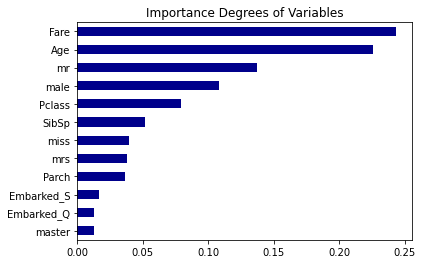

In [34]:
importance_degrees = pd.Series(data=rand_forest_cl.feature_importances_,
                        index= X_train.columns)

importance_degrees_sorted = importance_degrees.sort_values()

importance_degrees_sorted.plot(kind='barh', color='darkblue')
plt.title('Importance Degrees of Variables')
plt.show()

### ***Cross Validation***

In [35]:
rand_forest_cl = RandomForestClassifier(n_estimators=25, n_jobs=4, random_state=2)
cv = cross_validate(estimator=rand_forest_cl, X=X, y=y,
                    cv=10, scoring = ['accuracy', 'f1'])

print('accuracy scores mean     : ', cv['test_accuracy'].mean(), sep = '\n')
print("-"*30)
print('f1 scores mean      : ', cv['test_f1'].mean(), sep = '\n')
print("-"*30)

accuracy scores mean     : 
0.8070287141073658
------------------------------
f1 scores mean      : 
0.741734737841753
------------------------------


### ***Grid Search***

In [36]:
rand_forest_cl = RandomForestClassifier(n_jobs=4, random_state=2)
# model hangi parametreleri aliyor incele
print(rand_forest_cl.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}


In [37]:
parameters = {'max_depth': [x for x in range (3,11)], 
              'criterion': ['gini', 'entropy']}
grid_cv = GridSearchCV(estimator=rand_forest_cl, param_grid = parameters, 
                       cv = 10, scoring='f1')
grid_cv.fit(X, y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=4,
                                              oob_score=False, random_state=2,
                                     

In [265]:
print("En iyi parametreler : ", grid_cv.best_params_)
print("En iyi skor         : ", grid_cv.best_score_)

En iyi parametreler :  {'criterion': 'gini', 'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 5}
En iyi skor         :  0.7610543649478805


---

## ***Regression - House Prices***

- Regresyon projesinde House Prices verileriyle calismistik, burada da ayni veri setiyle calisacagiz.
- Temizlenmis ve aykiri degerlerden arindirilmis veri setiyle model olusturacagiz.

In [38]:
# temiz veri setini dataframe icerisine yukle
house_prices = pd.read_csv('data/house_prices_out.csv', index_col='Id')

In [5]:
house_prices

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,"2,003.000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.000,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,"1,999.000",RFn,2,460,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal,175000
1457,20,RL,85.000,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.000,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,"1,978.000",Unf,2,500,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1458,70,RL,66.000,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.000,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,"1,941.000",RFn,1,252,TA,TA,Y,0,60,0,0,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500


- Numerik olmayan degiskenler de encode edilerek numerik hale getirilir.

In [39]:
# kategorik degiskenleri encode eden fonksiyon
def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    # degerler index yapildi
    ordering.index = ordering.val
    # degisken degerlerinin SalePrice ortalamalarini aliyor
    ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    # ortalamalari siraliyor
    ordering = ordering.sort_values('spmean')
    # siralama degerleri ayri bir sutunda
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()    
    # en son soyle bir sozluk olusur ExterQual icin
    # {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    
    # burasi cok ilginc yeni encoded degiskeni burada olusturuyor
    for cat, o in ordering.items():        
        df.loc[df[feature] == cat, feature+'_E'] = o

In [40]:
# object tipinde olanlari ayir
qualitative = [column for column in house_prices.columns if house_prices.dtypes[column] == 'object']

# object tipinde olmayanlari ayir
quantitative = [column for column in house_prices.columns if house_prices.dtypes[column] != 'object']

qual_encoded = []
for q in qualitative:  
    encode(house_prices, q)
    qual_encoded.append(q+'_E')

quantitative.remove('SalePrice')
expl_vars = []
expl_vars = quantitative + qual_encoded

print('Min satis fiyati : {}\nMax satis fiyati : {}'.format(house_prices['SalePrice'].min(),
                                                            house_prices['SalePrice'].max()))

print('Aciklayici degisken adedi : {}'.format(len(expl_vars)))

Min satis fiyati : 34900
Max satis fiyati : 485000
Aciklayici degisken adedi : 79


### ***Random Forest modeli***

In [41]:
X = house_prices[expl_vars]
y = house_prices['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 111)

rand_forest_reg = RandomForestRegressor(n_estimators=25, n_jobs=4, random_state=2)

rand_forest_reg

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=4, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [42]:
rand_forest_reg.fit(X_train, y_train)

rand_forest_reg.score(X_test, y_test)

0.9044345819434688

### ***RMSE Score***

In [43]:
y_pred = rand_forest_reg.predict(X_test)
mse_rf = MSE(y_test, y_pred)
rmse_rf = mse_rf**(1/2)

# Print rmse
print("Random Forest RMSE score : {:.2f}".format(rmse_rf))

Random Forest RMSE score : 20370.36


### ***Cross Validation***

In [44]:
rand_forest_reg = RandomForestRegressor(n_estimators=25, n_jobs=4, random_state=2)
cv = cross_validate(estimator=rand_forest_reg, X=X, y=y,
                    cv=10, scoring = ['neg_root_mean_squared_error', 'r2'])

print('neg rmse scores mean     : ', cv['test_neg_root_mean_squared_error'].mean(), sep = '\n')
print("-"*30)
print('r2 scores mean      : ', cv['test_r2'].mean(), sep = '\n')
print("-"*30)

neg rmse scores mean     : 
-21828.32294334054
------------------------------
r2 scores mean      : 
0.8958355234408089
------------------------------


### ***Grid Search***

In [45]:
rand_forest_reg = RandomForestRegressor(n_jobs=4, random_state=2)
# model hangi parametreleri aliyor incele
print(rand_forest_reg.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}


In [13]:
parameters = {'max_depth': [x for x in range (3,11)], 
              'max_features': [x for x in range (1,4)]}
grid_cv = GridSearchCV(estimator=rand_forest_reg, param_grid = parameters, 
                       cv = 10, scoring='neg_root_mean_squared_error')
grid_cv.fit(X, y)

print("En iyi parametreler : ", grid_cv.best_params_)
print("En iyi skor         : ", grid_cv.best_score_)

En iyi parametreler :  {'max_depth': 10, 'max_features': 3}
En iyi skor         :  -23671.209685874033


In [14]:
grid_cv.cv_results_['mean_test_score']

array([-47941.26802432, -40269.98954626, -37331.94379545, -42575.90325387,
       -36714.43212536, -33022.63625577, -39283.18871592, -32947.27252028,
       -30193.30812057, -36813.19279387, -30847.69189051, -27882.44955985,
       -34487.18874288, -28600.52335499, -26377.7496302 , -32317.53086606,
       -27397.76904427, -25431.17396106, -30851.63583912, -26313.87011778,
       -24507.86717091, -29135.42061116, -25566.35672953, -23671.20968587])

In [15]:
parameters = {'max_depth': [x for x in range (3,11)]}
grid_cv = GridSearchCV(estimator=rand_forest_reg, param_grid = parameters, 
                       cv = 10, scoring='neg_root_mean_squared_error')
grid_cv.fit(X, y)

print("En iyi parametreler : ", grid_cv.best_params_)
print("En iyi skor         : ", grid_cv.best_score_)

En iyi parametreler :  {'max_depth': 10}
En iyi skor         :  -21671.139963458405


In [16]:
grid_cv.cv_results_['mean_test_score']

array([-30434.59284745, -26694.14240754, -24505.9008247 , -23185.80293137,
       -22374.19645494, -21901.82037053, -21702.65714206, -21671.13996346])

- ***???*** Grid search sadece max_depth parametresi ile daha iyi performans gosterdi.